In [8]:
# Dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import scipy.stats as st
from scipy.stats import linregress
import plotly.express as px
import seaborn as sns
from IPython.display import HTML, display


# Dependencies for GDP data
from pandas import ExcelWriter
from pandas import ExcelFile

In [9]:
# File to Load for Olympic Data
olympic_csv = "resources/athlete_events.csv"

# Read .csv File and store into Pandas data frame for Olympic Data
olympic_raw = pd.read_csv(olympic_csv)
pd.options.display.float_format = '{:.2f}'.format
olympic_raw.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.00,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.00,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.00,nan,nan,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.00,nan,nan,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.00,185.00,82.00,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [10]:
# remove all rows of data for Olympics taking place before the end of WW2 (1945).
olympic_raw_post_war = olympic_raw[olympic_raw.Year > 1945]

# summer olympic data, post WW2.
summer_olympics = olympic_raw_post_war[olympic_raw_post_war.Season != "Winter"]
summer_olympics

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.00,180.00,80.00,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.00,170.00,60.00,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
29,10,"Einar Ferdinand ""Einari"" Aalto",M,26.00,nan,nan,Finland,FIN,1952 Summer,1952,Summer,Helsinki,Swimming,Swimming Men's 400 metres Freestyle,NaN
31,12,Jyri Tapani Aalto,M,31.00,172.00,70.00,Finland,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,NaN
32,13,Minna Maarit Aalto,F,30.00,159.00,55.50,Finland,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271106,135565,Fernando scar Zylberberg,M,27.00,168.00,76.00,Argentina,ARG,2004 Summer,2004,Summer,Athina,Hockey,Hockey Men's Hockey,NaN
271107,135566,"James Francis ""Jim"" Zylker",M,21.00,175.00,75.00,United States,USA,1972 Summer,1972,Summer,Munich,Football,Football Men's Football,NaN
271108,135567,Aleksandr Viktorovich Zyuzin,M,24.00,183.00,72.00,Russia,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NaN
271109,135567,Aleksandr Viktorovich Zyuzin,M,28.00,183.00,72.00,Russia,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,NaN


In [11]:
# Importing cleaned GDP data
gdp_data = pd.read_excel("Country GDP Final.xls")
gdp_data.head()

,NOC,NOC Region,2000,2001,2002,2003,2004,2005,2006,2007,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,AFG,Afghanistan,nan,nan,4055176933.37,4515563413.83,5226775163.30,6209140044.01,6971286731.72,9747886104.53,...,12439087076.77,15856574731.44,17804280538.11,20001615788.67,20561054090.40,20484873230.21,19907111418.99,19362642266.65,20191764940.16,19362969582.36
1,ALB,Albania,3480355188.60,3922099470.97,4348070165.19,5611492282.87,7184681398.57,8052075642.11,8896073938.31,10677321490.38,...,12044223457.83,11926962834.96,12890867535.56,12319784701.33,12776277648.92,13228244336.32,11386927679.09,11861353752.07,13025064966.58,15102500898.24
2,ALG,Algeria,54786074940.21,54743249368.65,56758113501.17,67866141223.59,85324767230.49,103198442061.08,117030941571.94,134978727825.85,...,137214821177.36,161205065469.31,200015355528.47,209062886917.04,209754763860.68,213808808746.70,165978425168.39,160032930353.76,167390266100.76,173757952824.25
3,AND,Andorra,1434429703.34,1496912751.68,1733116883.12,2398645598.19,2935659299.73,3255789080.96,3543256805.92,4016972351.49,...,3660530702.97,3355695364.24,3442062830.14,3164615186.95,3281585236.33,3350736367.25,2811489408.89,2877311946.90,3013387423.94,3236543909.35
4,ANG,Angola,9129594818.61,8936063723.20,15285594828.42,17812705294.33,23552052407.55,36970918699.25,52381006892.04,65266452081.39,...,70307163678.24,83799496611.20,111789686464.44,128052853643.11,136709862831.19,145712200312.51,116193649124.15,101123851090.46,122123822333.59,105750987618.63


In [28]:
# Function to calculate medal count by Olympic year and merge GDP data by the same Olympic year
def olympic_year_medal_count(column, equal, condition):
    query = ' & '.join(f'{i} {j} {repr(k)}' for i, j, k in zip(column, equal, condition))
    df = (summer_olympics.query(query).dropna(how="any")
                                      .drop_duplicates(subset=['Event', 'NOC', 'Medal'])
                                      .NOC.value_counts()
                                      .to_frame(name = "Medal_Count")
                                      .rename_axis('NOC'))
    gdp_df = gdp_data.loc[: , ["NOC", condition[0]]]
    merge_df = pd.merge(df, gdp_df, on="NOC", how="left").dropna(how="any")
    # reset index to get rid of the drop index rows.  Creates new 0,1,2 ...
    # This resolved the KeyError in scatterplot function.  If this doesn't work,
    # use Try/Except block (KeyError was due to missing indexes)      
    merge_df = merge_df.reset_index() 
    merge_df = merge_df.drop("index", axis=1)
  
    return merge_df

# Function Calculating Regression 
def regression(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values , y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    r_squared = (rvalue**2)
       
    print(f"The correlation coefficient (rvalue) between {olympic_year} GDP and total medal count is: {round(rvalue, 6)}")
    print(f"The coefficient of determination (r-squared) value is: {round(r_squared, 6)}")
    
    return [regress_values, line_eq] # returns as a list

# Function Scatterplot
def scatterplot (df, x_values, y_values, regress, line): 

    x=x_values
    y=y_values
    fig, ax = plt.subplots(figsize=(10,5))
    colors = "blue"
    
    for i in range(len(df)):
        ax.scatter(x[i], y[i], color = colors, alpha=0.5)     
        
    limit = 10
    for i, type in enumerate(label):
        if i>= limit: 
            break
        else:
            x=x_values[i]
            y=y_values[i]
            plt.text(x, y, s=type, fontsize=9)
            
       
    ax.set_title(f"{olympic_year} Medal Count vs GDP")
    ax.set_xlabel("GDP (in $US) * 10 Trillion")
    ax.set_ylabel("Total Medal Count by NOC")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid()
    plt.annotate(line, (10000000000000, 10), fontsize=15, color="red") 
    plt.plot(x_values, regress, "r-") 
    plt.show()
    


The correlation coefficient (rvalue) between 2016 Rio Olympics GDP and total medal count is: 0.866557
The coefficient of determination (r-squared) value is: 0.750921


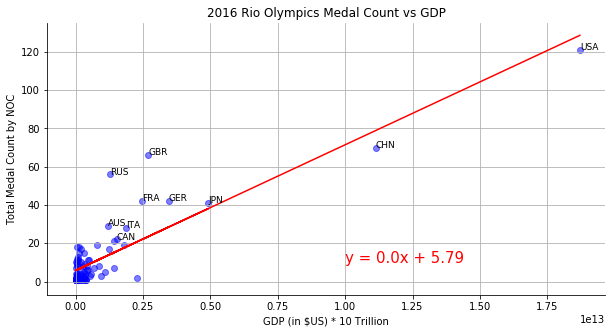

In [29]:
# Manipulate data to pass into functions (change lines 5,6 and 8)

column = ['Year']
equal = ['==']
condition = ["2016"]                                           # Change this year
olympic_year = "2016 Rio Olympics"                             # Change year/olympic city
merge_df = olympic_year_medal_count(column, equal, condition)
x_values = merge_df["2016"]                                    # Change GDP year
y_values = merge_df["Medal_Count"]
label = merge_df["NOC"]

regress, line = regression(x_values, y_values)

# Calling functions    
# olympic_year_medal_count()  - calling this function is not doing anything because I'm storing it in merge_df variable
scatterplot(merge_df, x_values, y_values, regress, line)